# Stokes flow

Here, we'll demonstrate a solution of the Stokes equations,
with Dirichlet (i.e. no-slip) boundary conditions on a surface.
The purpose of this case is to demonstrate the use of the tools with
vector-valued data -- in this case, the fluid velocity field.

After taking the curl of the velocity-pressure form of the Stokes equations, the governing
equations for this problem can be written as

$$\mu \nabla^2 \omega - \nabla \times (\delta(\chi) \mathbf{\sigma}) = \nabla\times \nabla \cdot (\delta(\chi)\mathbf{\Sigma})$$
$$\delta^T(\chi) \mathbf{v} = \overline{\mathbf{v}}_b$$
$$\mathbf{v} = \nabla \phi + \nabla\times \psi$$

where $\psi$ and $\phi$ are the solutions of

$$\nabla^2 \psi = -\omega$$
$$\nabla^2 \phi = \delta(\chi) \mathbf{n}\cdot [\mathbf{v}_b]$$

and $\mathbf{\Sigma} = \mu ([\mathbf{v}_b]\mathbf{n} + \mathbf{n} [\mathbf{v}_b] - \mathbf{n}\cdot[\mathbf{v}_b]\mathbf{I})$ is a surface viscous flux tensor;
and $[\mathbf{v}_b] = \mathbf{v}_b^+ - \mathbf{v}_b^-$ and $\overline{\mathbf{v}}_b = (\mathbf{v}_b^+ + \mathbf{v}_b^-)/2$ are
the jump and average of the surface velocities on either side of a surface.

We can discretize and combine these equations into a saddle-point form for $\psi$ and $\sigma$:

$$\begin{bmatrix}L^2 & C_s^T \\ C_s & 0 \end{bmatrix}\begin{pmatrix} \psi \\ \mathbf{\sigma} \end{pmatrix} = \begin{pmatrix} -C D_s [\mathbf{v}_b]  \\ \overline{\mathbf{v}}_b - G_s L^{-1} R \mathbf{n}\cdot [\mathbf{v}_b]  \end{pmatrix}$$

Note that $L^2$ represents the discrete biharmonic operator. (We have absorbed the
viscosity $\mu$ into the scaling of the problem.)

We can easily break this down into algorithmic form by the same block-LU decomposition
of other problems. The difference here is that $\mathbf{v}$ and $\mathbf{\sigma}$ are vector-valued,
so we treat this fundamentally as a vector-valued problem.

In [1]:
using ImmersedLayers
using Plots
using LinearAlgebra
using UnPack

## Set up the extra cache and solve function
The problem type is generated with the usual macro call, but now with `vector` type

In [2]:
@ilmproblem StokesFlow vector

As with other cases, the extra cache holds additional intermediate data, as well as
the Schur complement. We need a few more intermediate variable for this problem.
We'll also construct the filtering matrix for showing the traction field.

In [3]:
struct StokesFlowCache{SMT,SSMT,CMT,RCT,DVT,VNT,ST,VFT,FT} <: AbstractExtraILMCache
   S :: SMT
   Ss :: SSMT
   C :: CMT
   Rc :: RCT
   dv :: DVT
   vb :: DVT
   vprime :: DVT
   dvn :: VNT
   sstar :: ST
   vϕ :: VFT
   ϕ :: FT
end

Extend the `prob_cache` function to construct the extra cache

In [4]:
function ImmersedLayers.prob_cache(prob::StokesFlowProblem,base_cache::BasicILMCache)
    S = create_CL2invCT(base_cache)
    Ss = create_CLinvCT_scalar(base_cache)
    C = create_surface_filter(base_cache)

    dv = zeros_surface(base_cache)
    vb = zeros_surface(base_cache)
    vprime = zeros_surface(base_cache)

    dvn = ScalarData(dv)
    sstar = zeros_gridcurl(base_cache)
    vϕ = zeros_grid(base_cache)
    ϕ = Nodes(Primal,sstar)

    Rc = RegularizationMatrix(base_cache,dvn,ϕ)

    StokesFlowCache(S,Ss,C,Rc,dv,vb,vprime,dvn,sstar,vϕ,ϕ)
end

And finally, extend the `solve` function to do the actual solving.
We pass in the external and internal surface velocities via the `bc` keyword
The function returns the velocity field, streamfunction field, and surface
traction

In [5]:
function ImmersedLayers.solve(prob::StokesFlowProblem,sys::ILMSystem)
    @unpack extra_cache, base_cache, bc, phys_params = sys
    @unpack nrm = base_cache
    @unpack S, Ss, C, Rc, dv, vb, vprime, sstar, dvn, vϕ, ϕ  = extra_cache

    σ = zeros_surface(sys)
    s = zeros_gridcurl(sys)
    v = zeros_grid(sys)

    # Get the jumps in velocity across surface
    prescribed_surface_jump!(dv,sys)

    # Compute ψ*
    surface_divergence_symm!(v,dv,sys)
    curl!(sstar,v,sys)
    sstar .*= -1.0

    inverse_laplacian!(sstar,sys)
    inverse_laplacian!(sstar,sys)

    # Adjustment for jump in normal velocity
    pointwise_dot!(dvn,nrm,dv)
    regularize!(ϕ,dvn,Rc)
    inverse_laplacian!(ϕ,sys)
    grad!(vϕ,ϕ,sys)

    # Get the average velocity on the surface
    prescribed_surface_average!(vb,sys)
    interpolate!(vprime,vϕ,sys)
    vprime .= vb - vprime

    # Compute surface velocity due to ψ*
    curl!(v,sstar,sys)
    interpolate!(vb,v,sys)

    # Spurious slip
    vprime .-= vb
    σ .= S\vprime

    # Correction streamfunction
    surface_curl!(s,σ,sys)
    s .*= -1.0
    inverse_laplacian!(s,sys)
    inverse_laplacian!(s,sys)

    # Correct
    s .+= sstar

    # Assemble the velocity
    curl!(v,s,sys)
    v .+= vϕ

    # Add the streamfunction equivalent to scalar potential
    ds = zeros_surfacescalar(base_cache)
    surface_grad_cross!(ds,ϕ,base_cache)
    ds .= Ss\ds
    surface_curl_cross!(sstar,ds,base_cache)
    sstar .*= -1.0
    inverse_laplacian!(sstar,base_cache)
    s .+= sstar

    # Filter the traction twice to clean it up a bit
    σ .= C^2*σ

    return v, s, σ
end

## Set up a grid, body, and boundary conditions
We'll consider a rectangle here

In [6]:
Δx = 0.01
Lx = 4.0
xlim = (-Lx/2,Lx/2)
ylim = (-Lx/2,Lx/2)
g = PhysicalGrid(xlim,ylim,Δx)
Δs = 1.4*cellsize(g)
body = Rectangle(0.5,0.25,Δs)

Closed polygon with 4 vertices and 214 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


Set up the boundary condition functions and assemble them into a `Dict`.
We will consider the flow generated by simply translating the body to the right
at unit velocity. We set the external $x$ velocity to 1 and $y$ velocity to zero. The
internal velocity we set to zero.

In [7]:
function get_vsplus(base_cache,phys_params)
    vsplus = zeros_surface(base_cache)
    vsplus.u .= 1.0
    return vsplus
end
get_vsminus(base_cache,phys_params) = zeros_surface(base_cache)

bcdict = Dict("exterior"=>get_vsplus,"interior"=>get_vsminus)

Dict{String, Function} with 2 entries:
  "interior" => get_vsminus
  "exterior" => get_vsplus

Set up the problem and the system, passing in the boundary condition information

In [8]:
prob = StokesFlowProblem(g,body,scaling=GridScaling,bc=bcdict)
sys = construct_system(prob);

## Solve the problem

In [9]:
solve(prob,sys) #hide
@time v, s, σ = solve(prob,sys)
nothing #hide

  0.118557 seconds (2.16 k allocations: 23.541 MiB, 5.51% compilation time)


Let's look at the velocity components

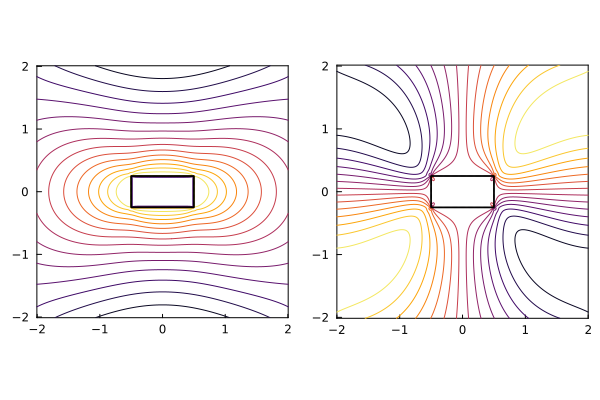

In [10]:
plot(v,sys)

Note that the velocity is zero inside, as desired. Let's look at the streamlines here

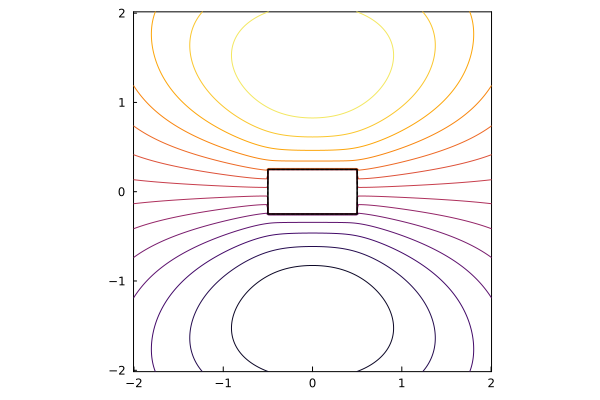

In [11]:
plot(s,sys)

We'll plot the surface traction components, too.

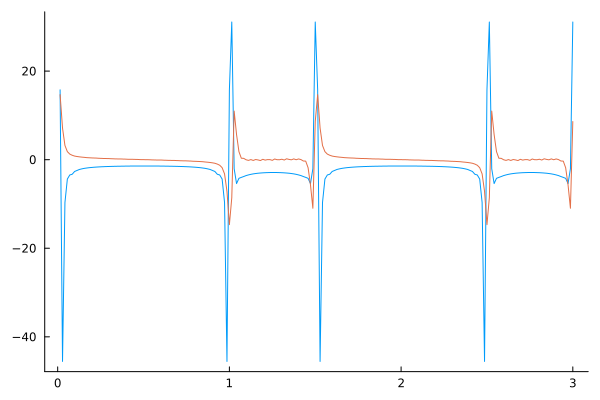

In [12]:
plot(σ.u,sys,label="σx")
plot!(σ.v,sys,label="σy")

Now, let's apply a different motion, where we rotate it counter-clockwise
at unit angular velocity. We simply re-define the external velocity function.

In [13]:
function get_vsplus(base_cache,phys_params)
    pts = points(base_cache)
    vsplus = zeros_surface(base_cache)
    vsplus.u .= -pts.v
    vsplus.v .= pts.u
    return vsplus
end

get_vsplus (generic function with 1 method)

Solve it again and plot the velocity and streamlines

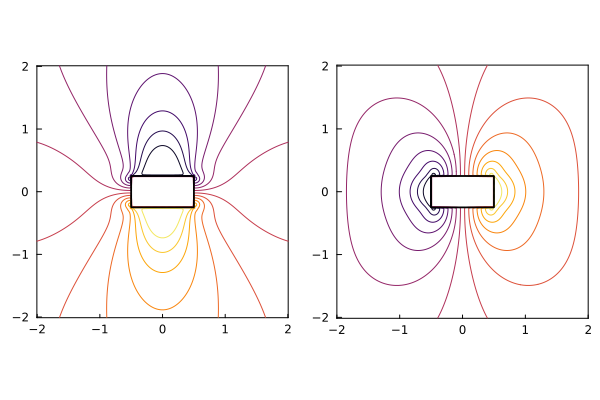

In [14]:
v, s, σ = solve(prob,sys)
plot(v,sys)

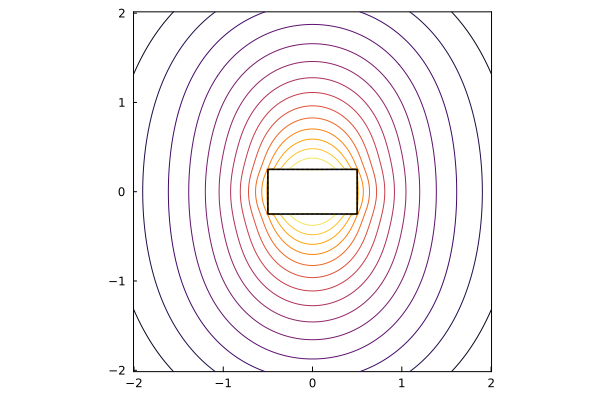

In [15]:
plot(s,sys)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*